In [3]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(plyr)
library(purrr)
library(rstatix)
library(ggpubr)
library(ggsci)
library(ggrepel)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




In [4]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}


# Total T

In [5]:
freq=read.csv('freq_T.csv')

In [6]:
last_chars <- sapply(freq$sample.visitName, function(string) {
  substr(string, nchar(string), nchar(string))
})
freq$visit<-paste0("Y",freq$Flu_Year,'-D',last_chars)
freq<-freq %>% group_by(sample.sampleKitGuid) %>%     
  dplyr::mutate(frequency_clr = clr_transform((frequency))) %>%
  dplyr::ungroup()

### Freq-CLR

In [8]:
Year='2020'

In [14]:
STAT_res<-freq %>%filter(Flu_Year==Year) %>%
  select(frequency_clr,labels,Flu_Year, cohort.cohortGuid, subject.subjectGuid,visit) %>%
  unique(.) %>%
  group_by(labels,cohort.cohortGuid) %>% arrange(subject.subjectGuid, visit) %>%
  wilcox_test(frequency_clr ~ visit, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

labels,cohort.cohortGuid,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
CXCR5+ PD1+ Tfh,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,198,3.37e-04,0.00539200,**
CXCR5+ PD1+ Tfh,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,185,9.03e-05,0.00288960,**
CXCR5+ PD1- Tfh,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,293,1.76e-02,0.08045714,ns
CXCR5+ PD1- Tfh,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,378,1.17e-01,0.26742857,ns
cd103_cd4_t_cells,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,523,7.51e-01,0.95525926,ns
cd103_cd4_t_cells,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,700,3.91e-02,0.13902222,ns


In [15]:
max_y<-freq %>%
  filter(Flu_Year == Year) %>%
  select(frequency_clr, labels, Flu_Year, cohort.cohortGuid, visit) %>%
  distinct() %>%
  group_by(labels, cohort.cohortGuid) %>%
  dplyr::summarize(max_frequency_clr = max(frequency_clr)) %>%
  ungroup() %>% arrange(labels,cohort.cohortGuid) %>% select(max_frequency_clr) %>% pull()

`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


In [16]:
STAT_res<-STAT_res%>% arrange(labels,cohort.cohortGuid)

In [17]:
STAT_res$max_y<-max_y*1.1

In [18]:
STAT_res$p<-round(STAT_res$p,4)
STAT_res$p.adj<-round(STAT_res$p.adj,4)

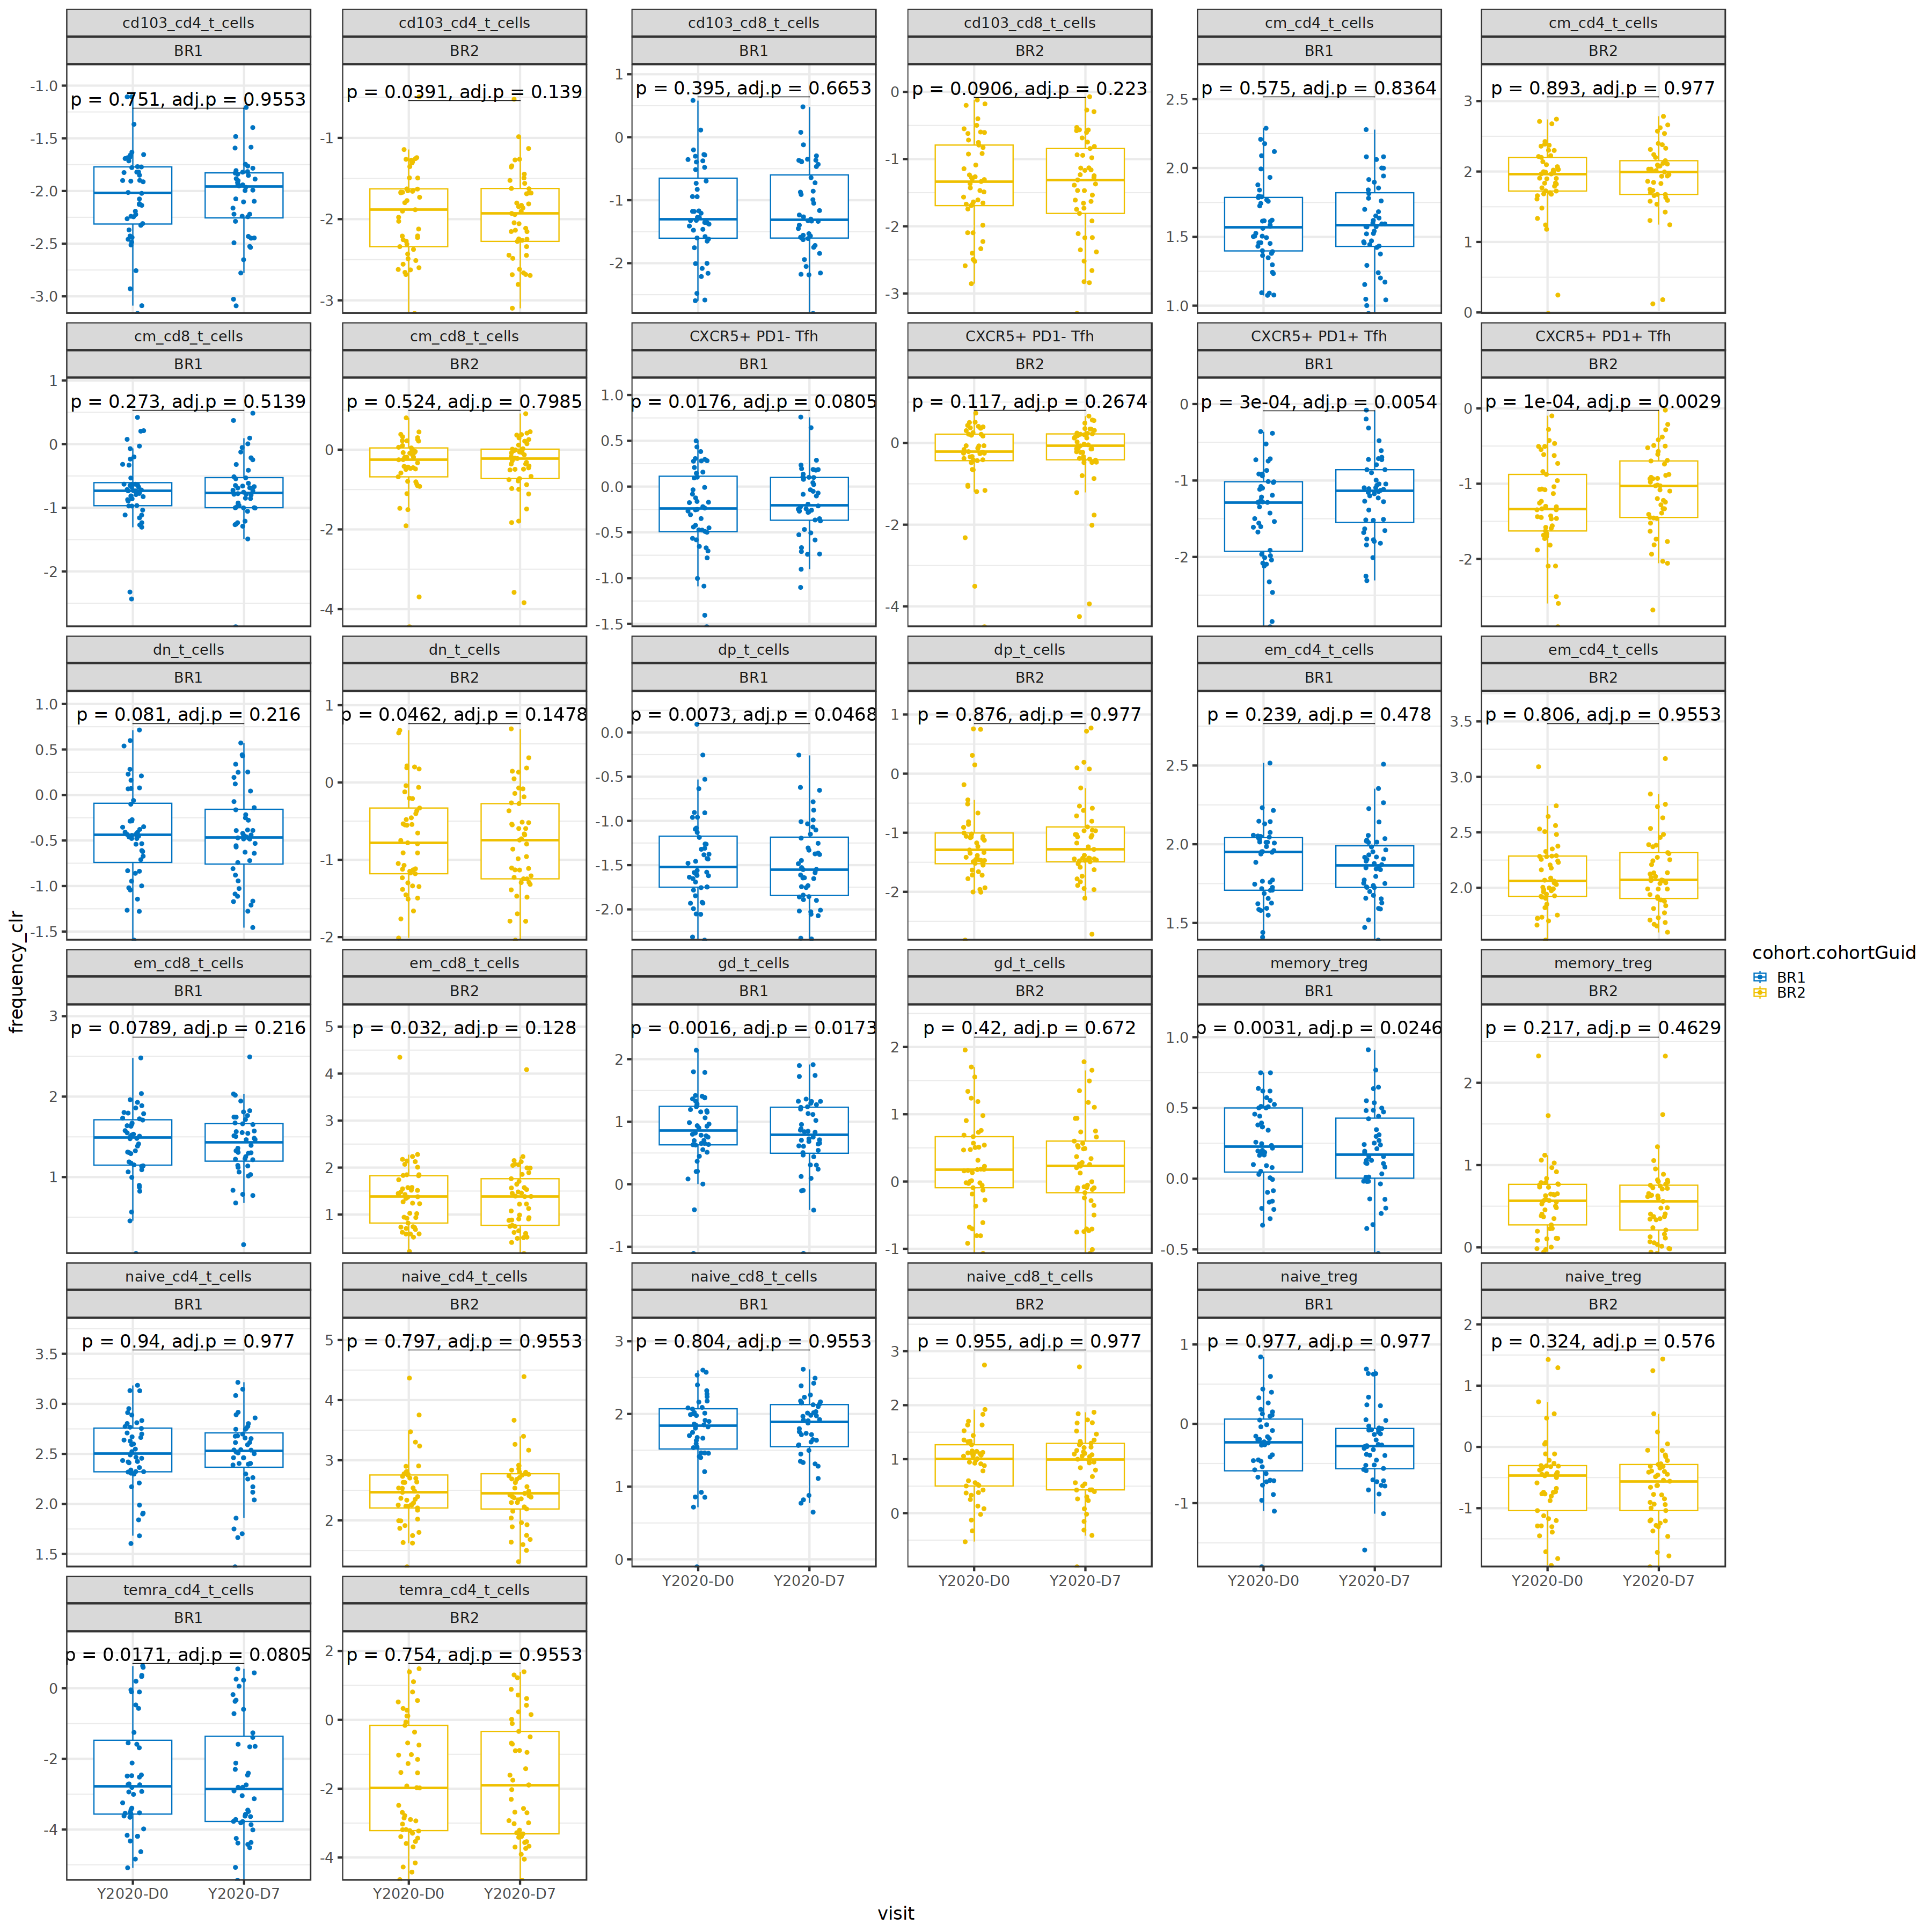

In [19]:
options(repr.plot.width = 30, repr.plot.height = 30)


ggboxplot(freq %>%filter(Flu_Year==Year), x = "visit", y = "frequency_clr",color='cohort.cohortGuid',
           palette = "jco",add = "jitter")+
facet_wrap(~labels+cohort.cohortGuid,scale='free_y',ncol=6)+   
stat_pvalue_manual(STAT_res, label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, 
                   y.position = 'max_y', x.position=0.5,size=7) +
theme_bw(base_size=20)+
scale_y_continuous(limits = c(NA, NA), expand = expansion(mult = c(0, 0.15)))

### Freq

In [21]:
STAT_res<-freq %>%filter(Flu_Year==Year) %>%
  select(frequency,labels,Flu_Year, cohort.cohortGuid,subject.subjectGuid, visit) %>%
  unique(.) %>%
  group_by(labels,cohort.cohortGuid) %>% arrange(subject.subjectGuid, visit) %>%
  wilcox_test(frequency ~ visit, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

labels,cohort.cohortGuid,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
CXCR5+ PD1+ Tfh,BR1,frequency,Y2020-D0,Y2020-D7,44,44,239,0.00230,0.0368000,*
CXCR5+ PD1+ Tfh,BR2,frequency,Y2020-D0,Y2020-D7,45,45,251,0.00214,0.0368000,*
CXCR5+ PD1- Tfh,BR1,frequency,Y2020-D0,Y2020-D7,44,44,333,0.05900,0.2360000,ns
CXCR5+ PD1- Tfh,BR2,frequency,Y2020-D0,Y2020-D7,45,45,421,0.28200,0.6445714,ns
cd103_cd4_t_cells,BR1,frequency,Y2020-D0,Y2020-D7,44,44,500,0.95900,0.9820000,ns
cd103_cd4_t_cells,BR2,frequency,Y2020-D0,Y2020-D7,45,45,669,0.08840,0.3091200,ns


In [22]:
max_y<-freq %>%
  filter(Flu_Year == Year) %>%
  select(frequency, labels, Flu_Year, cohort.cohortGuid, visit) %>%
  distinct() %>%
  group_by(labels, cohort.cohortGuid) %>%
  dplyr::summarize(max_frequency = max(frequency)) %>%
  ungroup() %>% arrange(labels,cohort.cohortGuid) %>% select(max_frequency) %>% pull()

`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


In [23]:
STAT_res<-STAT_res%>% arrange(labels,cohort.cohortGuid)

In [24]:
STAT_res$max_y<-max_y*1.1

In [25]:
STAT_res$p<-round(STAT_res$p,5)
STAT_res$p.adj<-round(STAT_res$p.adj,5)

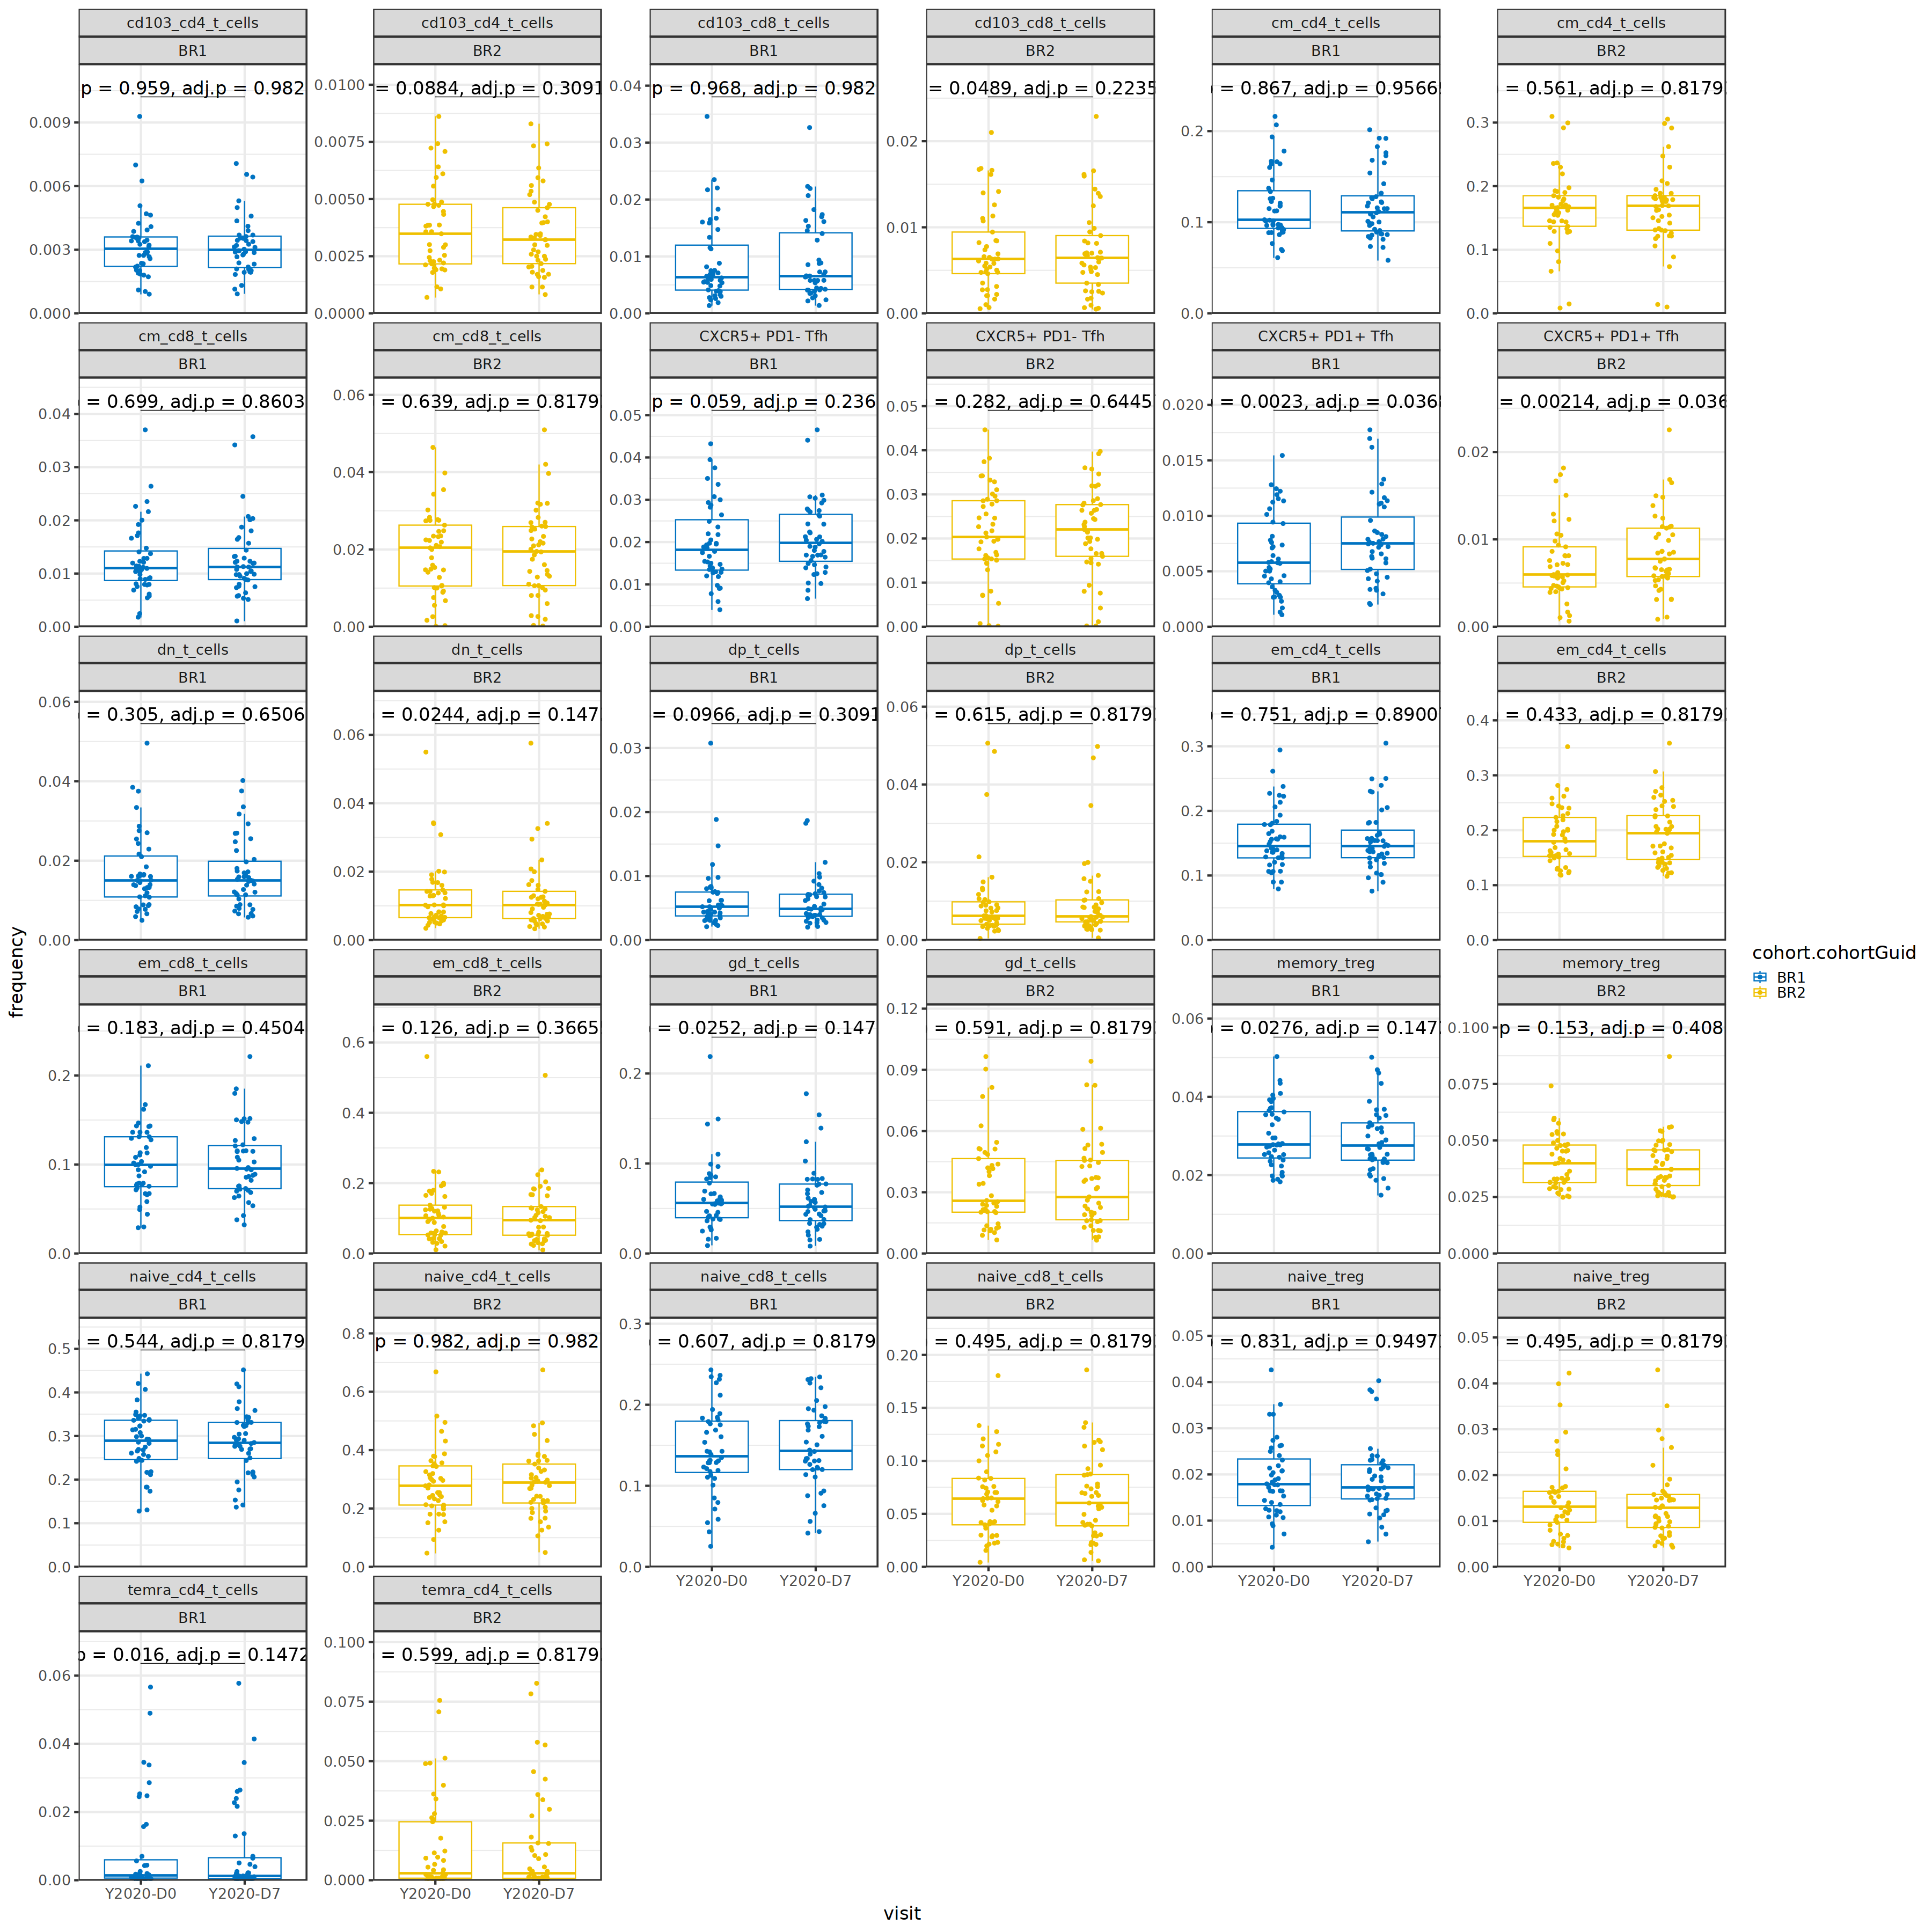

In [26]:
options(repr.plot.width = 30, repr.plot.height = 30)


ggboxplot(freq %>%filter(Flu_Year==Year), x = "visit", y = "frequency",color='cohort.cohortGuid',
           palette = "jco",add = "jitter")+
facet_wrap(~labels+cohort.cohortGuid,scale='free_y',ncol=6)+   
stat_pvalue_manual(STAT_res, label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, y.position = 'max_y', x.position=0.5,size=7) +
theme_bw(base_size=20)+
  scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0, 0.15)))

# Total T

In [27]:
freq=read.csv('freq_CD4_T.csv')

In [28]:
last_chars <- sapply(freq$sample.visitName, function(string) {
  substr(string, nchar(string), nchar(string))
})
freq$visit<-paste0("Y",freq$Flu_Year,'-D',last_chars)
freq<-freq %>% group_by(sample.sampleKitGuid) %>%     
  dplyr::mutate(frequency_clr = clr_transform((frequency))) %>%
  dplyr::ungroup()

### Freq-CLR

In [340]:
Year='2020'

In [29]:

STAT_res<-freq %>%filter(Flu_Year==Year) %>%
  select(frequency_clr,labels,Flu_Year, cohort.cohortGuid, subject.subjectGuid,visit) %>%
  unique(.) %>%
  group_by(labels,cohort.cohortGuid) %>% arrange(subject.subjectGuid, visit)%>%
  wilcox_test(frequency_clr ~ visit, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

labels,cohort.cohortGuid,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
CXCR5+ PD1+ Tfh,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,174,9.18e-05,0.00082620,***
CXCR5+ PD1+ Tfh,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,185,9.03e-05,0.00082620,***
CXCR5+ PD1- Tfh,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,322,4.33e-02,0.08660000,ns
CXCR5+ PD1- Tfh,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,392,1.60e-01,0.26181818,ns
cd103_cd4_t_cells,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,607,1.95e-01,0.28800000,ns
cd103_cd4_t_cells,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,716,2.44e-02,0.06891429,ns


In [30]:
max_y<-freq %>%
  filter(Flu_Year == Year) %>%
  select(frequency_clr, labels, Flu_Year, cohort.cohortGuid, visit) %>%
  distinct() %>%
  group_by(labels, cohort.cohortGuid) %>%
  dplyr::summarize(max_frequency_clr = max(frequency_clr)) %>%
  ungroup() %>% arrange(labels,cohort.cohortGuid) %>% select(max_frequency_clr) %>% pull()

`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


In [31]:
STAT_res<-STAT_res%>% arrange(labels,cohort.cohortGuid)

In [32]:
STAT_res$max_y<-max_y*1.1

In [33]:
STAT_res$p<-round(STAT_res$p,4)
STAT_res$p.adj<-round(STAT_res$p.adj,4)

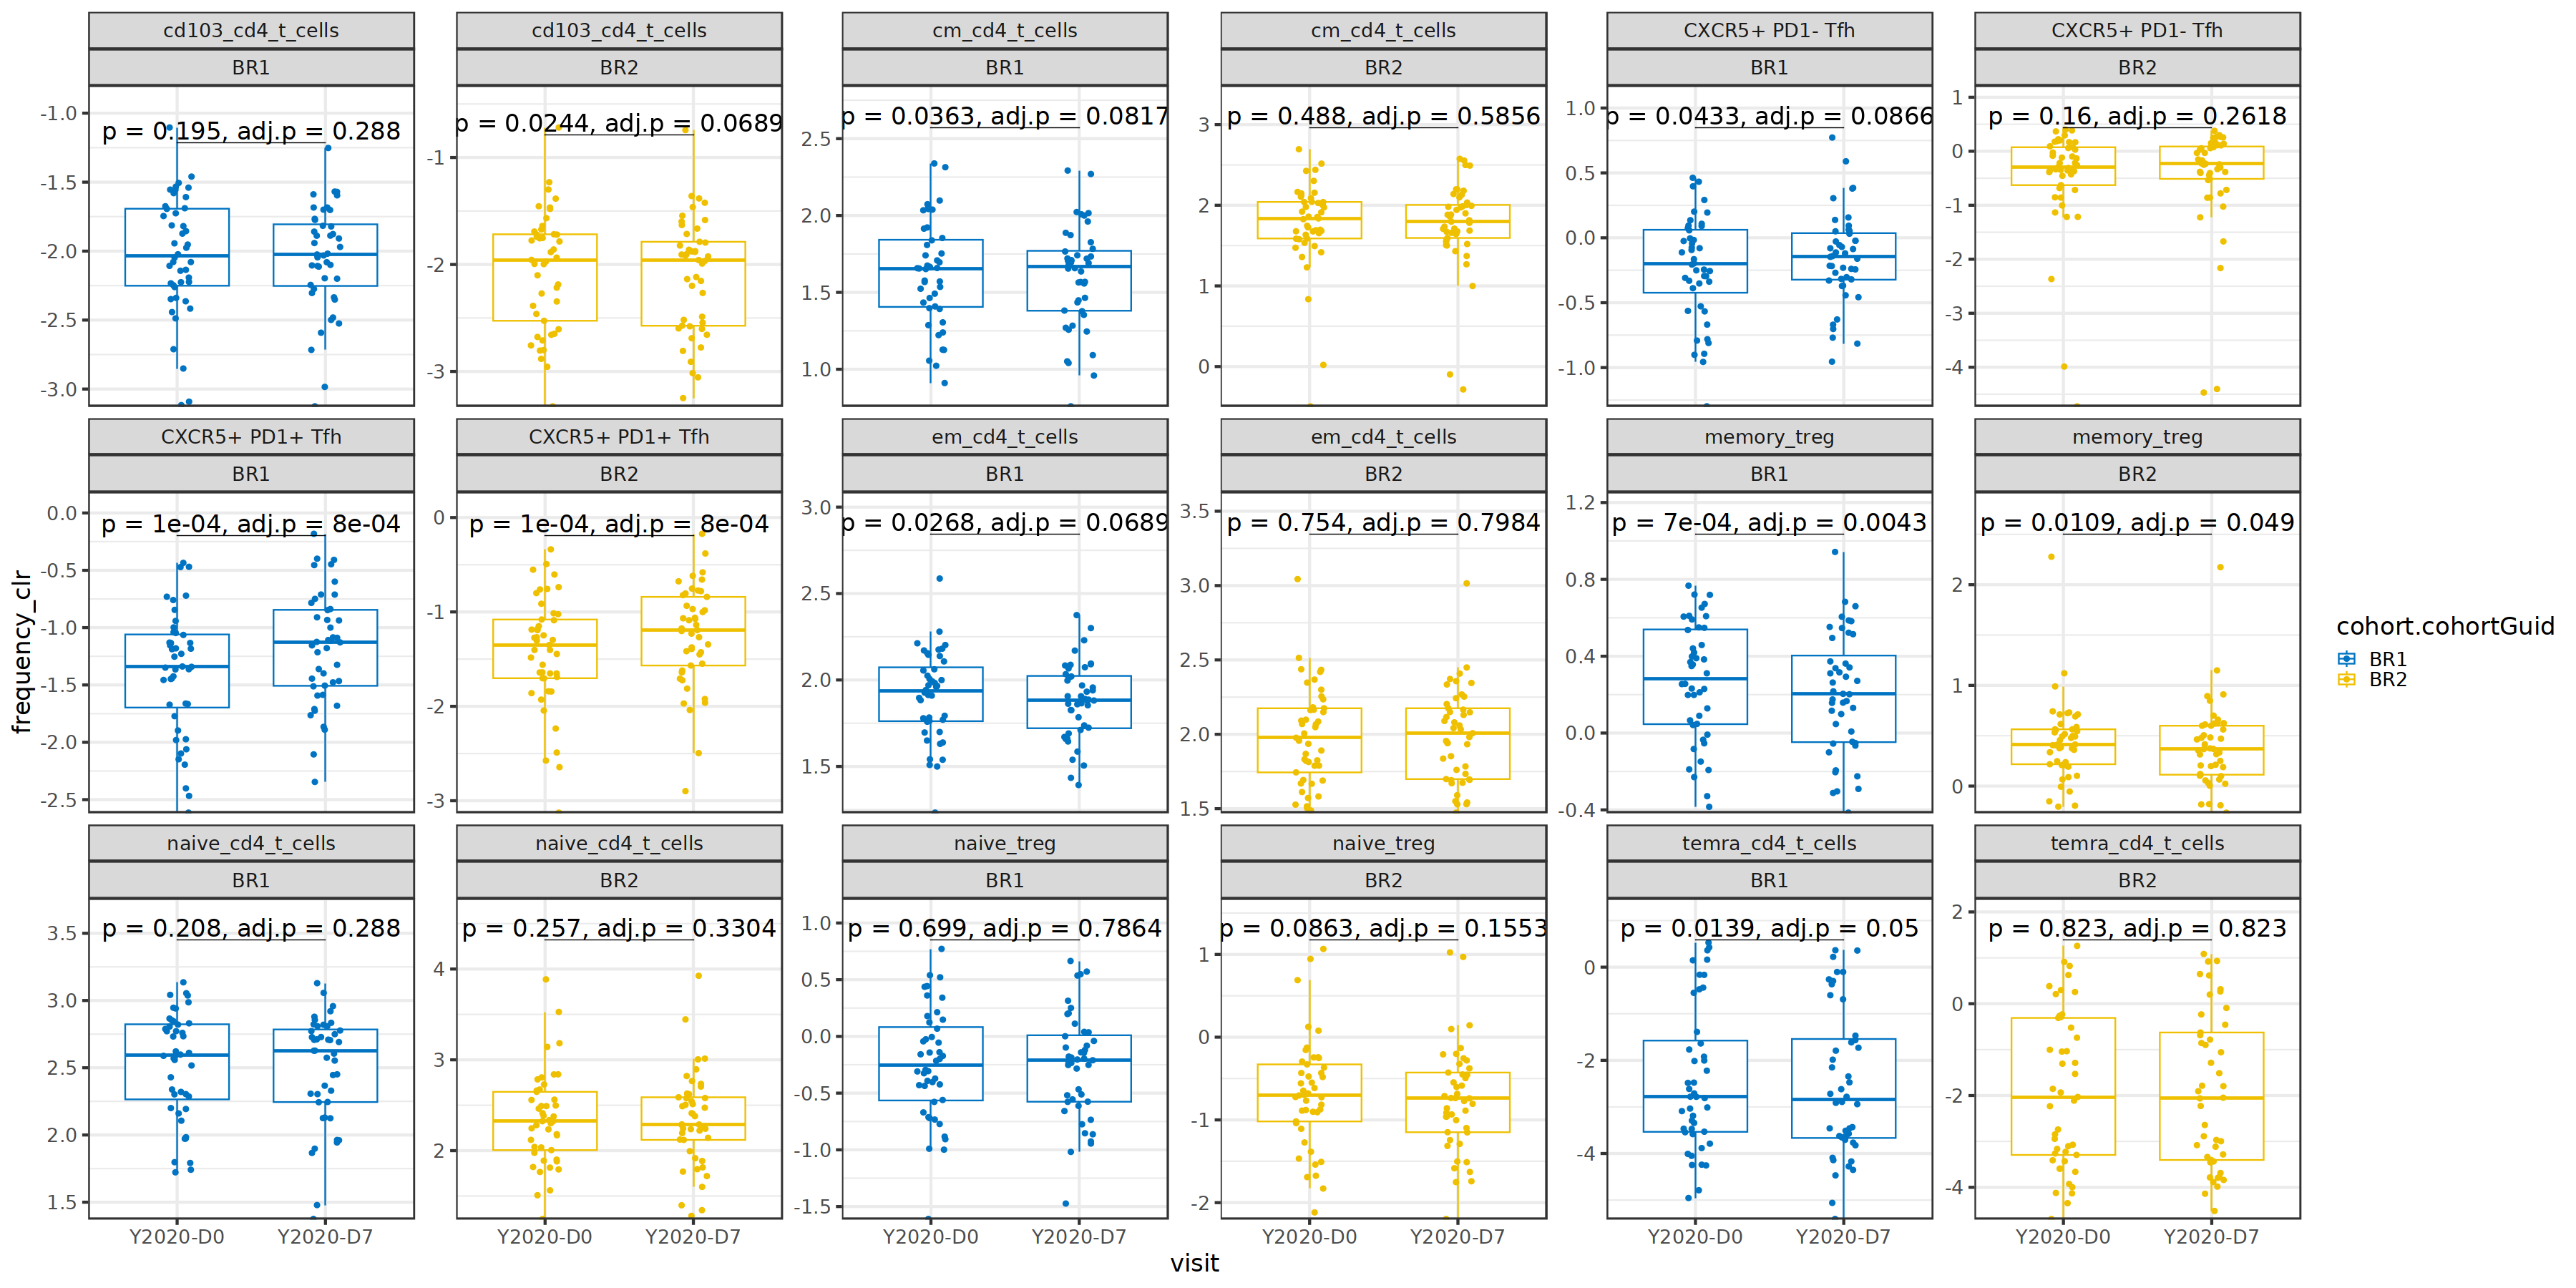

In [34]:
options(repr.plot.width = 30, repr.plot.height = 15)


ggboxplot(freq %>%filter(Flu_Year==Year), x = "visit", y = "frequency_clr",color='cohort.cohortGuid',
           palette = "jco",add = "jitter")+
facet_wrap(~labels+cohort.cohortGuid,scale='free_y',ncol=6)+   
stat_pvalue_manual(STAT_res, label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, 
                   y.position = 'max_y', x.position=0.5,size=7) +
theme_bw(base_size=20)+
scale_y_continuous(limits = c(NA, NA), expand = expansion(mult = c(0, 0.15)))

### Freq

In [35]:
STAT_res<-freq %>%filter(Flu_Year==Year) %>%
  select(frequency,labels,Flu_Year, cohort.cohortGuid, subject.subjectGuid,visit) %>%
  unique(.) %>%
  group_by(labels,cohort.cohortGuid) %>%arrange(subject.subjectGuid, visit)%>%
  wilcox_test(frequency ~ visit, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

labels,cohort.cohortGuid,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
CXCR5+ PD1+ Tfh,BR1,frequency,Y2020-D0,Y2020-D7,44,44,214,0.000744,0.013392,*
CXCR5+ PD1+ Tfh,BR2,frequency,Y2020-D0,Y2020-D7,45,45,243,0.001530,0.013770,*
CXCR5+ PD1- Tfh,BR1,frequency,Y2020-D0,Y2020-D7,44,44,317,0.037400,0.136800,ns
CXCR5+ PD1- Tfh,BR2,frequency,Y2020-D0,Y2020-D7,45,45,426,0.308000,0.693000,ns
cd103_cd4_t_cells,BR1,frequency,Y2020-D0,Y2020-D7,44,44,517,0.804000,0.925875,ns
cd103_cd4_t_cells,BR2,frequency,Y2020-D0,Y2020-D7,45,45,701,0.038000,0.136800,ns


In [36]:
max_y<-freq %>%
  filter(Flu_Year == Year) %>%
  select(frequency, labels, Flu_Year, cohort.cohortGuid, visit) %>%
  distinct() %>%
  group_by(labels, cohort.cohortGuid) %>%
  dplyr::summarize(max_frequency = max(frequency)) %>%
  ungroup() %>% arrange(labels,cohort.cohortGuid) %>% select(max_frequency) %>% pull()

`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


In [37]:
STAT_res<-STAT_res%>% arrange(labels,cohort.cohortGuid)

In [38]:
STAT_res$max_y<-max_y*1.1

In [39]:
STAT_res$p<-round(STAT_res$p,5)
STAT_res$p.adj<-round(STAT_res$p.adj,5)

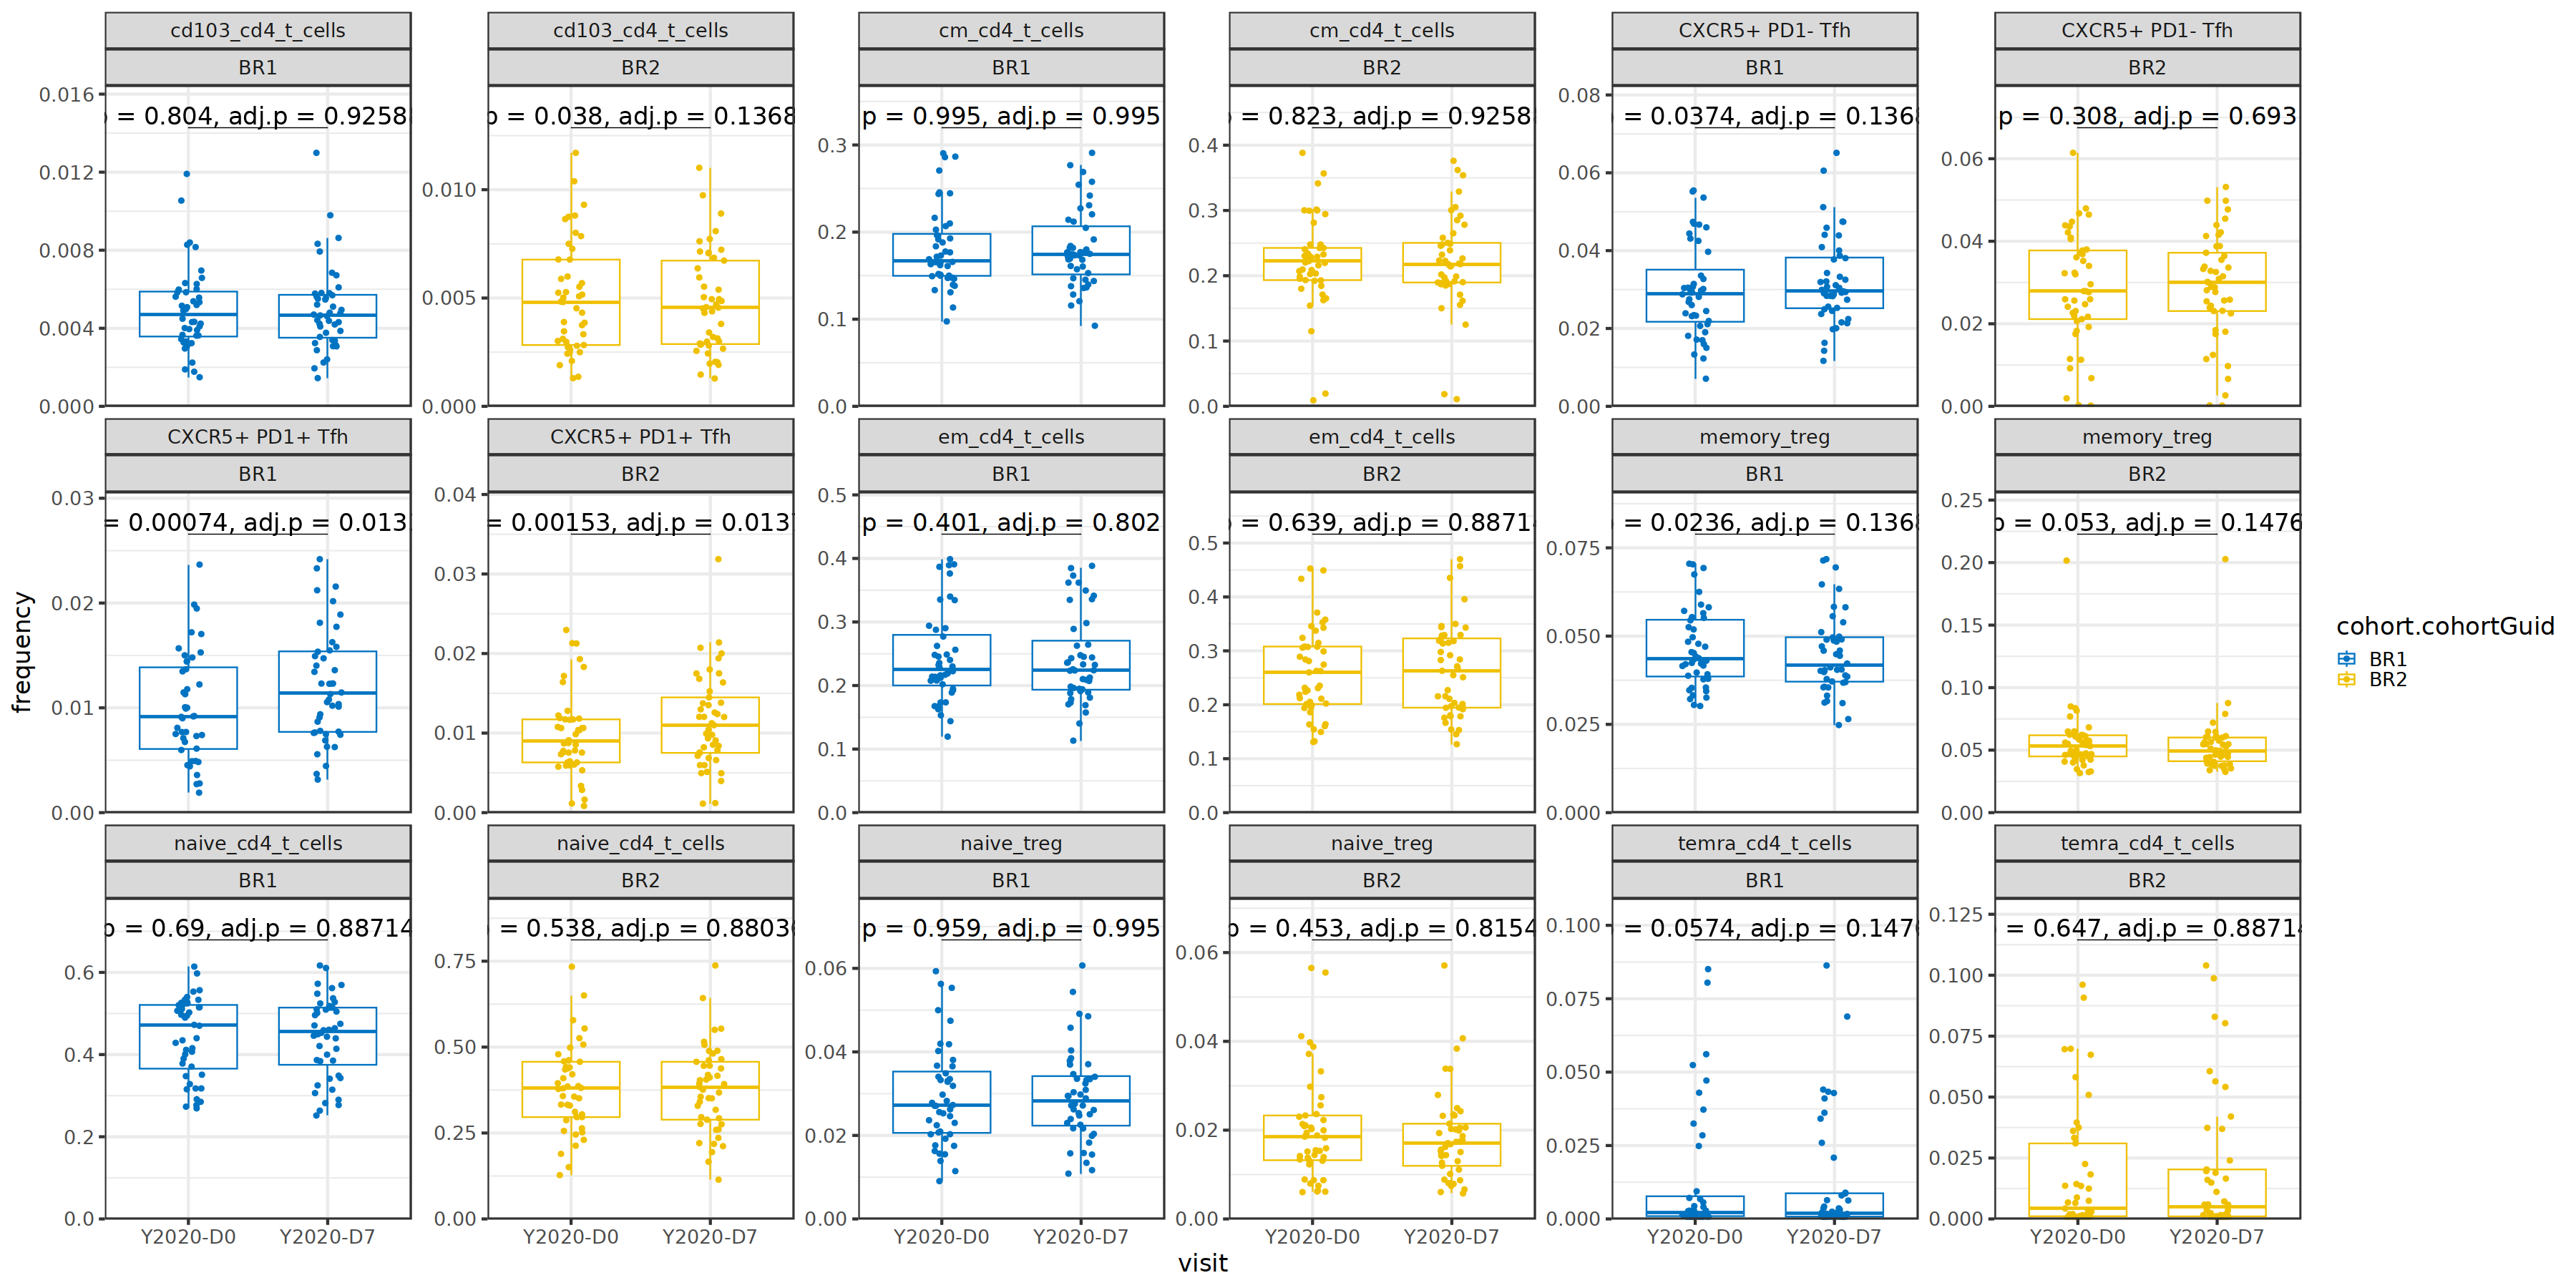

In [40]:
options(repr.plot.width = 30, repr.plot.height = 15)


ggboxplot(freq %>%filter(Flu_Year==Year), x = "visit", y = "frequency",color='cohort.cohortGuid',
           palette = "jco",add = "jitter")+
facet_wrap(~labels+cohort.cohortGuid,scale='free_y',ncol=6)+   
stat_pvalue_manual(STAT_res, label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, y.position = 'max_y', x.position=0.5,size=7) +
theme_bw(base_size=20)+
  scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0, 0.15)))

In [7]:
unique(freq$labels)

[1] "CXCR5+ PD1+ Tfh"   "CXCR5+ PD1- Tfh"   "cd103_cd4_t_cells"
 [4] "cd103_cd8_t_cells" "cm_cd4_t_cells"    "cm_cd8_t_cells"   
 [7] "dn_t_cells"        "dp_t_cells"        "em_cd4_t_cells"   
[10] "em_cd8_t_cells"    "gd_t_cells"        "memory_treg"      
[13] "naive_cd4_t_cells" "naive_cd8_t_cells" "naive_treg"       
[16] "temra_cd4_t_cells"

In [22]:
stat.test2 <- freq %>%filter(Flu_Year=='2020',labels %in%c('CXCR5+ PD1+ Tfh') ) %>% 
group_by(cohort.cohortGuid)%>% arrange(subject.subjectGuid, visit)%>%
  wilcox_test(frequency_clr ~ visit, paire=TRUE,p.adjust.method = "BH")
stat.test2

,cohort.cohortGuid,.y.,group1,group2,n1,n2,statistic,p
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,BR1,frequency_clr,Y2020-D0,Y2020-D7,44,44,198,3.37e-04
2,BR2,frequency_clr,Y2020-D0,Y2020-D7,45,45,185,9.03e-05


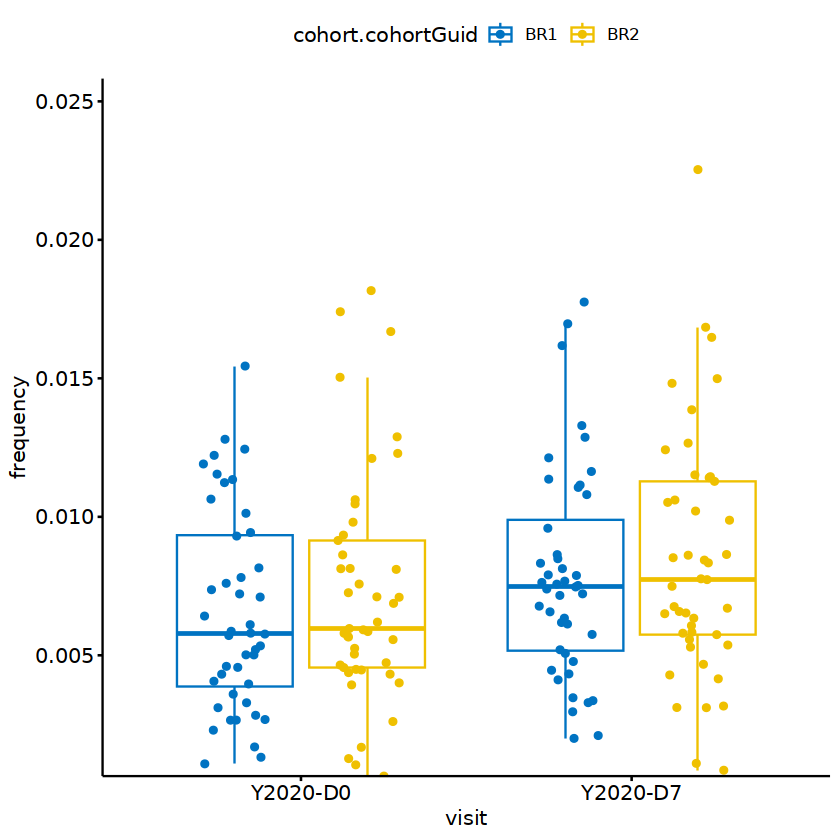

In [30]:

ggboxplot(freq %>%filter(Flu_Year=='2020',labels %in%c('CXCR5+ PD1+ Tfh') ), x = "visit", y = "frequency",color='cohort.cohortGuid',
           palette = "jco",add = "jitter")+
scale_y_continuous(limits = c(NA, NA), expand = expansion(mult = c(0, 0.15)))